In [1]:
from scipy.stats import expon
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import pickle
import numpy as np
import geopandas as gpd
# from geopandas import GeoDataFrame
import matplotlib
from matplotlib import pyplot

In [2]:
def train(X, Y):
    """
    Train classification algorithm.
    
    Train the Support Vector Machine classification algorithm using the
    specified fields. 

    Parameters
    ----------
    X: numpy 2D array
        A 2D numpy array where there is one row for each segment and each
        column represents an attribute of the segments. 

    Y: numpy 1D array
        A 1D numpy array equal in length to the number of records in segments.
        The single column contains actual class values for each of the
        segments.

    output_filename: string
        Output filename of the pickled trained SVM model.

    Returns
    -------
    model: svm.SVC
        Returns a trained SVM model that can be used to classify other data.

    """
    clf = svm.SVC()
        
    # specify parameters and distributions to sample from
    param_dist = {'C': expon(scale=100),
                  'gamma': expon(scale=.1),
                  'kernel': ['rbf'],
                  'class_weight':['balanced', None]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

    random_search.fit(X, Y) # this may take time...
    
    return random_search

In [3]:
def predict(model, X):
    """
    Classify segments using a trained SVM model

    Classify image segments using the trained Support Vector Machine model. 

    Parameters
    ----------
     model: svm.SVC
        A trained SVM model that can be used to classify other data.

    X: numpy 2D array
        A 2D numpy array where there is one row for each segment and each
        column represents an attribute of the segments. Identical to segments
        from the train_classifier function.
    """
    predictions = model.predict(X)

    return predictions

In [4]:
for_training = gpd.read_file("classified.gpkg", layer="classified")

In [5]:
for_training.head

<bound method NDFrame.head of       red_min  red_max     red_mean     red_std  green_min  green_max  \
0         0.0   1433.0   411.413793  461.613775        0.0     1654.0   
1      1927.0   2081.0  2006.000000   62.933828     2140.0     2244.0   
2      1019.0   1019.0  1019.000000    0.000000     1214.0     1214.0   
3       686.0    888.0   811.800000   68.819765      849.0     1109.0   
4       609.0    647.0   628.000000   19.000000      762.0      807.0   
...       ...      ...          ...         ...        ...        ...   
3179    859.0   1615.0  1113.633803  127.778444     1047.0     1785.0   
3180    446.0   2834.0   644.519690  107.643272      525.0     3008.0   
3181    690.0   1907.0  1011.882353  258.059531      877.0     2044.0   
3182    488.0   1913.0   642.254941   93.160359      608.0     2180.0   
3183    366.0   2068.0   667.287810  154.154120      489.0     2208.0   

       green_mean   green_std  blue_min  blue_max  ...  major_axis_length  \
0      498.96551

In [6]:
big_train = for_training[~for_training["classify"].isnull()]

In [7]:
big_train.head

<bound method NDFrame.head of       red_min  red_max     red_mean     red_std  green_min  green_max  \
263     834.0    834.0   834.000000    0.000000     1016.0     1016.0   
268     817.0    817.0   817.000000    0.000000     1039.0     1039.0   
271     782.0    782.0   782.000000    0.000000     1033.0     1033.0   
288     402.0    532.0   461.292359   24.027688      545.0      644.0   
289    1504.0   1504.0  1504.000000    0.000000     1630.0     1630.0   
...       ...      ...          ...         ...        ...        ...   
3178    475.0   1397.0   856.940426  147.482118      645.0     1533.0   
3179    859.0   1615.0  1113.633803  127.778444     1047.0     1785.0   
3180    446.0   2834.0   644.519690  107.643272      525.0     3008.0   
3182    488.0   1913.0   642.254941   93.160359      608.0     2180.0   
3183    366.0   2068.0   667.287810  154.154120      489.0     2208.0   

       green_mean   green_std  blue_min  blue_max  ...  major_axis_length  \
263   1016.00000

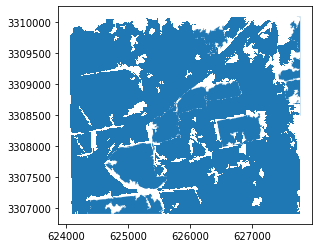

In [8]:
big_train.plot()

In [9]:
big_train.columns.values

array(['red_min', 'red_max', 'red_mean', 'red_std', 'green_min',
       'green_max', 'green_mean', 'green_std', 'blue_min', 'blue_max',
       'blue_mean', 'blue_std', 'area', 'perimeter', 'eccentricity',
       'equivalent_diameter', 'major_axis_length', 'minor_axis_length',
       'orientation', 'sobel_min', 'sobel_max', 'sobel_mean', 'sobel_std',
       'dn', 'classify', 'geometry'], dtype=object)

In [10]:
labels = big_train['classify']

In [11]:
labels

263        pipeline
268        pipeline
271        pipeline
288     undeveloped
289        pipeline
           ...     
3178      developed
3179       pipeline
3180    undeveloped
3182    undeveloped
3183      developed
Name: classify, Length: 1604, dtype: object

In [12]:
classes = big_train[['red_mean', 'green_mean', "blue_mean", "eccentricity", "orientation", "sobel_max"]]

In [13]:
classes

,red_mean,green_mean,blue_mean,eccentricity,orientation,sobel_max
263,834.000000,1016.000000,1183.000000,0.000000,0.785398,0.000935
268,817.000000,1039.000000,1201.000000,0.000000,0.785398,0.001511
271,782.000000,1033.000000,1205.000000,0.000000,0.785398,0.000603
288,461.292359,587.810631,619.000000,0.448089,0.484576,0.000796
289,1504.000000,1630.000000,1871.000000,0.000000,0.785398,0.003395
...,...,...,...,...,...,...
3178,856.940426,1036.927660,1251.274468,0.948390,-1.253177,0.005553
3179,1113.633803,1326.985915,1626.760563,0.883412,-0.022390,0.003429
3180,644.519690,754.433149,891.067656,0.970622,-1.556443,0.012192
3182,642.254941,747.430498,845.835924,0.827680,1.068733,0.007444


In [14]:
type(classes)

pandas.core.frame.DataFrame

In [15]:
type(labels)

pandas.core.series.Series

In [16]:
model = train(classes, labels)

/home/davidm/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [17]:
type(model)

sklearn.model_selection._search.RandomizedSearchCV

In [18]:
test = predict(model,classes)

In [19]:
type(test)

numpy.ndarray

In [20]:
print(test)

['pipeline' 'pipeline' 'pipeline' ... 'undeveloped' 'undeveloped'
 'developed']


In [21]:
print(len(test))

1604


In [22]:
big_train["new_class"] = test

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
big_train

,red_min,red_max,red_mean,red_std,green_min,green_max,green_mean,green_std,blue_min,blue_max,...,minor_axis_length,orientation,sobel_min,sobel_max,sobel_mean,sobel_std,dn,classify,geometry,new_class
263,834.0,834.0,834.000000,0.000000,1016.0,1016.0,1016.000000,0.000000,1183.0,1183.0,...,0.000000,0.785398,9.350821e-04,0.000935,0.000935,0.000000,306,pipeline,"POLYGON ((627138.000 3309828.000, 627138.000 3...",pipeline
268,817.0,817.0,817.000000,0.000000,1039.0,1039.0,1039.000000,0.000000,1201.0,1201.0,...,0.000000,0.785398,1.511110e-03,0.001511,0.001511,0.000000,313,pipeline,"POLYGON ((627132.000 3309822.000, 627132.000 3...",pipeline
271,782.0,782.0,782.000000,0.000000,1033.0,1033.0,1033.000000,0.000000,1205.0,1205.0,...,0.000000,0.785398,6.032864e-04,0.000603,0.000603,0.000000,317,pipeline,"POLYGON ((627126.000 3309819.000, 627126.000 3...",pipeline
288,402.0,532.0,461.292359,24.027688,545.0,644.0,587.810631,15.074368,560.0,730.0,...,18.959941,0.484576,3.428548e-19,0.000796,0.000260,0.000147,279,undeveloped,"POLYGON ((626589.000 3309867.000, 626589.000 3...",undeveloped
289,1504.0,1504.0,1504.000000,0.000000,1630.0,1630.0,1630.000000,0.000000,1871.0,1871.0,...,0.000000,0.785398,3.395030e-03,0.003395,0.003395,0.000000,330,pipeline,"POLYGON ((627054.000 3309804.000, 627054.000 3...",pipeline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,475.0,1397.0,856.940426,147.482118,645.0,1533.0,1036.927660,156.021531,678.0,1842.0,...,15.216057,-1.253177,4.055141e-05,0.005553,0.001252,0.000893,3121,developed,"POLYGON ((626298.000 3306966.000, 626298.000 3...",developed
3179,859.0,1615.0,1113.633803,127.778444,1047.0,1785.0,1326.985915,121.962069,1288.0,2033.0,...,8.879229,-0.022390,1.010010e-04,0.003429,0.000871,0.000595,3136,pipeline,"POLYGON ((624204.000 3306948.000, 624204.000 3...",pipeline
3180,446.0,2834.0,644.519690,107.643272,525.0,3008.0,754.433149,117.830792,603.0,3343.0,...,108.042573,-1.556443,3.814755e-06,0.012192,0.000336,0.000510,2879,undeveloped,"POLYGON ((625344.000 3307224.000, 625344.000 3...",undeveloped
3182,488.0,1913.0,642.254941,93.160359,608.0,2180.0,747.430498,109.825184,652.0,2522.0,...,123.474627,1.068733,3.066587e-19,0.007444,0.000327,0.000484,2821,undeveloped,"POLYGON ((625971.000 3307302.000, 625971.000 3...",undeveloped


In [26]:
test_set = for_training[['red_mean', 'green_mean', "blue_mean", "eccentricity", "orientation", "sobel_max"]]

In [28]:
final_predict = predict(model,test_set)

In [29]:
for_training["new_class"] = final_predict

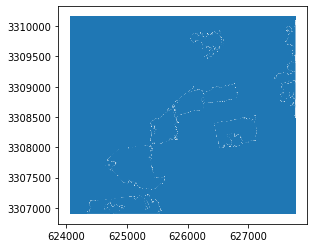

In [32]:
for_training.plot()
for_training.head()
for_training.to_file("some_name.shp")

In [34]:
import time

In [35]:
time_start = time.clock()
# Use training data to classify a new window.
next_window = gpd.read_file("geobia2.gpkg", layer="ready2classify")
next_window_set = next_window[['red_mean', 'green_mean', "blue_mean", "eccentricity", "orientation", "sobel_max"]]
next_window_predict = predict(model,next_window_set)
next_window["new_class"] = next_window_predict
next_window.to_file("next_window.shp")
time_elapsed = (time.clock() - time_start)
print("CPU")
print(time_elapsed)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


CPU
2.6677859999999995


/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
